In [1]:
import pandas as pd
import janitor
import numpy as np
import ast
from tqdm.notebook import tqdm
from pranaam import pranaam
from outkast import secc_caste
from naampy import predict_fn_gender
import warnings
warnings.filterwarnings('ignore')

FP = '2008ner.csv.gz'

In [2]:
df = (pd.read_csv(FP, compression='gzip')
      .assign(persons='')
     )
df.head(3)

,objecttype,numericpubdate,date,year,completed,ner,persons
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",
1,"['Feature', 'Article']",20080302,2008-03-02,2008,True,"[('24 hours', 'TIME'), ('Mumbai', 'GPE'), ('Me...",
2,"['Feature', 'Article']",20081225,2008-12-25,2008,True,"[('Navy', 'ORG'), ('Chidambaram', 'WORK_OF_ART...",


In [3]:
len(df)

103894

In [4]:
# get person only
for ix, row in tqdm(df.iterrows()):
    persons = row['persons']
    if persons!='':
        continue
    else:
        persons = []
        
    ners = row['ner']
    ners = ast.literal_eval(ners)
    for ner in ners:
        entity, entitytype = ner
        if entitytype.lower()=="person":    
            persons.append(entity)
    
    df.at[ix, 'persons'] = persons
#     print(persons)

0it [00:00, ?it/s]

In [5]:
df = (df
      .explode(column='persons')
      .assign(
          last=lambda df: df.persons.apply(lambda x: str(x).split(' ')[-1])
      )
     )
df.head(3)

,objecttype,numericpubdate,date,year,completed,ner,persons,last
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Ranbir Kapoor,Kapoor
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Sanjay Leela Bhansali,Bhansali
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Bipasha Basu,Basu


In [6]:
# Get religion
df = (df
      .merge(pranaam.pred_rel(df.drop_duplicates('persons').persons.tolist()), 
             how='left', left_on='persons', right_on='name', validate='m:1')
      .rename_column('pred_label', 'pred_religion')
      .assign(pred_muslim=lambda df: np.where(df.pred_religion=="muslim", 1, 0))
      .remove_columns('name')
     )
df.head(3)

Model path D:\ProgramData\Anaconda3\lib\site-packages\pranaam\model


,objecttype,numericpubdate,date,year,completed,ner,persons,last,pred_religion,pred_prob_muslim,pred_muslim
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Ranbir Kapoor,Kapoor,not-muslim,37.0,0
1,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Sanjay Leela Bhansali,Bhansali,not-muslim,27.0,0
2,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Bipasha Basu,Basu,not-muslim,28.0,0


In [7]:
# Get caste
df = (df.merge((secc_caste(df.drop_duplicates('last'), 'last')
                .filter(['last', 'n_sc', 'n_st', 'n_other', 'prop_sc', 'prop_st','prop_other'])
               ), 
               how='left', on='last', validate='m:1')
      .assign(pred_caste=lambda df: df[['prop_sc', 'prop_st', 'prop_other']].idxmax(axis=1))
     )
df.head(3)

,objecttype,numericpubdate,date,year,completed,ner,persons,last,pred_religion,pred_prob_muslim,pred_muslim,n_sc,n_st,n_other,prop_sc,prop_st,prop_other,pred_caste
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Ranbir Kapoor,Kapoor,not-muslim,37.0,0,387.0,33.0,1384.0,0.214523,0.018293,0.767184,prop_other
1,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Sanjay Leela Bhansali,Bhansali,not-muslim,27.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Bipasha Basu,Basu,not-muslim,28.0,0,2304.0,226.0,7973.0,0.219366,0.021518,0.759116,prop_other


In [8]:
personslist = df['persons'].dropna().tolist()
df = (df.merge((predict_fn_gender(personslist)
                .drop_duplicates(subset='name')
                .dropna(subset='pred_gender')
               ), 
               left_on='persons', right_on='name', how='left', validate='m:1')
     )
df.head(3)

,objecttype,numericpubdate,date,year,completed,ner,persons,last,pred_religion,pred_prob_muslim,...,n_sc,n_st,n_other,prop_sc,prop_st,prop_other,pred_caste,name,pred_gender,pred_prob
0,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Ranbir Kapoor,Kapoor,not-muslim,37.0,...,387.0,33.0,1384.0,0.214523,0.018293,0.767184,prop_other,NaN,NaN,NaN
1,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Sanjay Leela Bhansali,Bhansali,not-muslim,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Review,20080810,2008-08-10,2008,True,"[('Ranbir Kapoor', 'PERSON'), ('three', 'CARDI...",Bipasha Basu,Basu,not-muslim,28.0,...,2304.0,226.0,7973.0,0.219366,0.021518,0.759116,prop_other,NaN,NaN,NaN


### Viz

In [9]:
def change_barwidth(ax, new_value):
    # https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid')  #  Darkgrid Whitegrid Dark White Ticks

#### Religion

Text(0.5, 1.0, 'Religion representation')

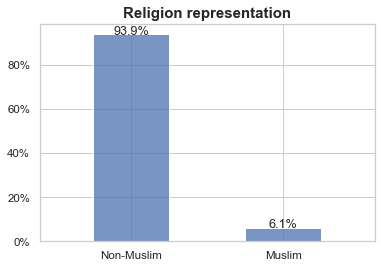

In [11]:
_, ax = plt.subplots()

sns.histplot(x='pred_religion', data=df, stat='percent', ax=ax)
ax.set_xticklabels(['Non-Muslim', 'Muslim'])
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel(''), plt.xlabel('')
change_barwidth(ax, .5)

perc_muslim = 100*(1-df.pred_muslim.mean())
perc_nonmuslim = 100*df.pred_muslim.mean()
ax.text(x=0, y=perc_muslim, s=f'{perc_muslim:.1f}%', ha="center")    
ax.text(x=1, y=perc_nonmuslim, s=f'{perc_nonmuslim:.1f}%', ha="center")   
plt.title('Religion representation', fontweight='bold', size=15)

#### Castes

Text(0.5, 1.0, 'Caste representation')

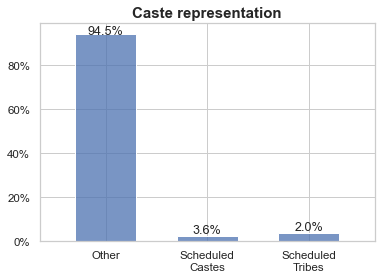

In [12]:
_, ax = plt.subplots()

sns.histplot(x='pred_caste', data=df, stat='percent', ax=ax)
ax.set_xticklabels(['Other', 'Scheduled\nCastes', 'Scheduled\nTribes'])
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel(''), plt.xlabel('')
change_barwidth(ax, .6)

perc_other = 100*(len(df.query('pred_caste=="prop_other"'))/len(df.dropna(subset='pred_caste')))
perc_sc = 100*(len(df.query('pred_caste=="prop_sc"'))/len(df.dropna(subset='pred_caste')))
perc_st = 100*(len(df.query('pred_caste=="prop_st"'))/len(df.dropna(subset='pred_caste')))
ax.text(x=0, y=perc_other, s=f'{perc_other:.1f}%', ha="center")    
ax.text(x=1, y=perc_sc, s=f'{perc_sc:.1f}%', ha="center")  
ax.text(x=2, y=perc_st+3, s=f'{perc_st:.1f}%', ha="center")  
plt.title('Caste representation', fontweight='bold', size=15)

#### Gender

Text(0.5, 1.0, 'Gender representation')

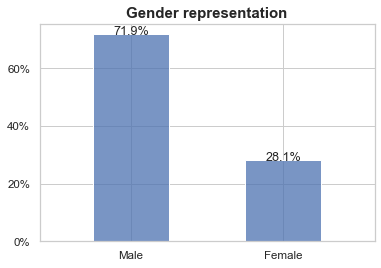

In [13]:
_, ax = plt.subplots()

sns.histplot(x='pred_gender', data=df, stat='percent', ax=ax)
ax.set_xticklabels(['Male', 'Female'])
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel(''), plt.xlabel('')
ax.set_yticks([0, 20, 40, 60])
change_barwidth(ax, .5)

_df = df.dropna(subset='pred_gender')
perc_female = 100*(len(_df.query('pred_gender=="female"'))/len(_df))
perc_male = 100*(len(_df.query('pred_gender=="male"'))/len(_df))
ax.text(x=0, y=perc_male, s=f'{perc_male:.1f}%', ha="center")    
ax.text(x=1, y=perc_female, s=f'{perc_female:.1f}%', ha="center")   
plt.title('Gender representation', fontweight='bold', size=15)

#### Top people mentions

In [14]:
df_people = (df.groupby('persons').size().reset_index()
             .rename_column(0, 'cites')
             .sort_values('cites', ascending=False)
             .reset_index(drop=True)
            )
df_people.head(3)

,persons,cites
0,Patil,1851
1,Goa,1539
2,Bush,1371


In [15]:
def draw_alt_row_colors(ax, rowspan=5, color='0.5', alpha=0.1):
    yticks = ax.get_yticks()
    counter = 1
    for ix, _ in enumerate(yticks):
        if ix%rowspan==0:
            if counter%2==0:
                ax.axhspan(ix-.5, ix+rowspan-.5, color=color, alpha=alpha, zorder=0)
            counter += 1
    return ax

Text(0, 0.5, '')

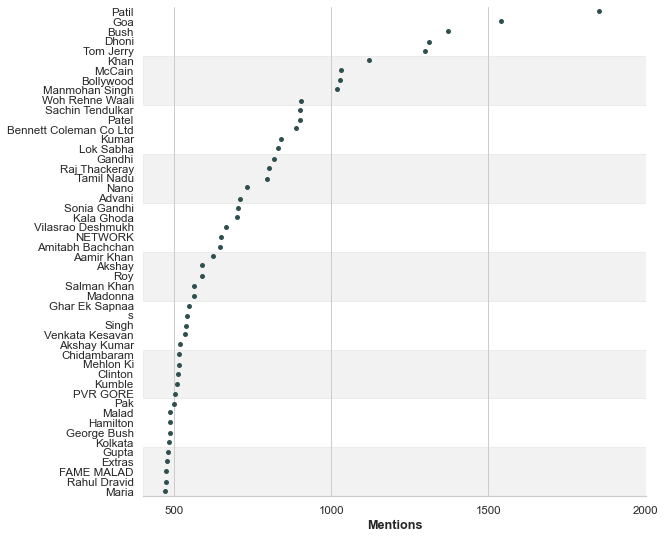

In [16]:
_, ax = plt.subplots(figsize=(9,9))
sns.stripplot(x='cites', y='persons', data=df_people.head(50), 
              orient='h', color='darkslategray', ax=ax)
draw_alt_row_colors(ax)
ax.set_ylim(50-.5, -.5)
sns.despine(left=True)
plt.xticks(range(500,2500,500))
plt.xlabel('Mentions', fontweight='bold')
plt.ylabel('')

#### Countries

In [17]:
df['places'] = ''

# get person only
for ix, row in tqdm(df.iterrows()):
    places = row['places']
    if places!='':
        continue
    else:
        places = []
        
    ners = row['ner']
    ners = ast.literal_eval(ners)
    for ner in ners:
        entity, entitytype = ner
        if entitytype.lower()=="gpe":    
            places.append(entity)
    
    df.at[ix, 'places'] = places
#     print(persons)

0it [00:00, ?it/s]

In [18]:
df_places = (df.explode(column='places')
             .dropna(subset='places')
             .groupby('places').size().reset_index()
             .rename_column(0, 'cites')
             .sort_values('cites', ascending=False)
            )
df_places

,places,cites
8114,India,544506
13175,Mumbai,343722
11418,MD,132450
21146,US,129038
15225,Pakistan,89044
...,...,...
8788,Jeddah Saudi Arabia's,1
8786,Jeanhis Biguine,1
21110,Twothirds,1
8770,Jayantha Dhanapala,1


Text(0, 0.5, '')

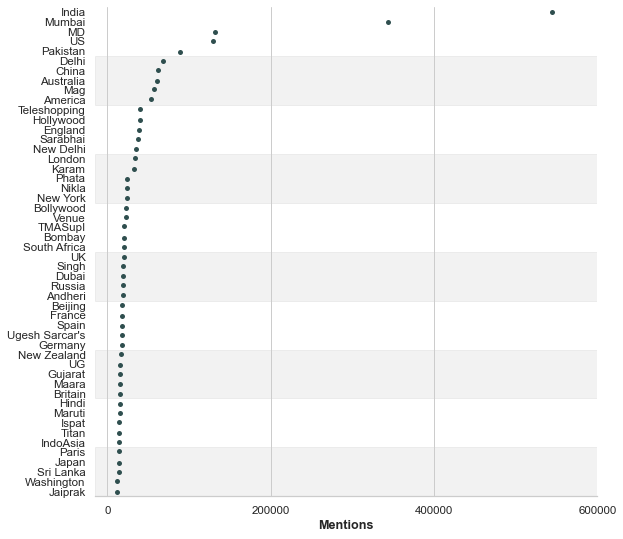

In [19]:
_, ax = plt.subplots(figsize=(9,9))
sns.stripplot(x='cites', y='places', data=df_places.head(50), 
              orient='h', color='darkslategray', ax=ax)
draw_alt_row_colors(ax)
ax.set_ylim(50-.5, -.5)
sns.despine(left=True)
plt.xticks(range(0,800_000,200_000))
plt.xlabel('Mentions', fontweight='bold')
plt.ylabel('')